# Gaussian Process Regression using Spectral Mixture Kernels

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;
$('.nbp-app-bar').toggle()

<IPython.core.display.Javascript object>

In [2]:
import gpflow
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import sys
import os
sys.path.append('/l/gadichs1/gitrepos/aalto/gprsm')

from gprsm.spectralmixture import SpectralMixture, sm_init

# Data

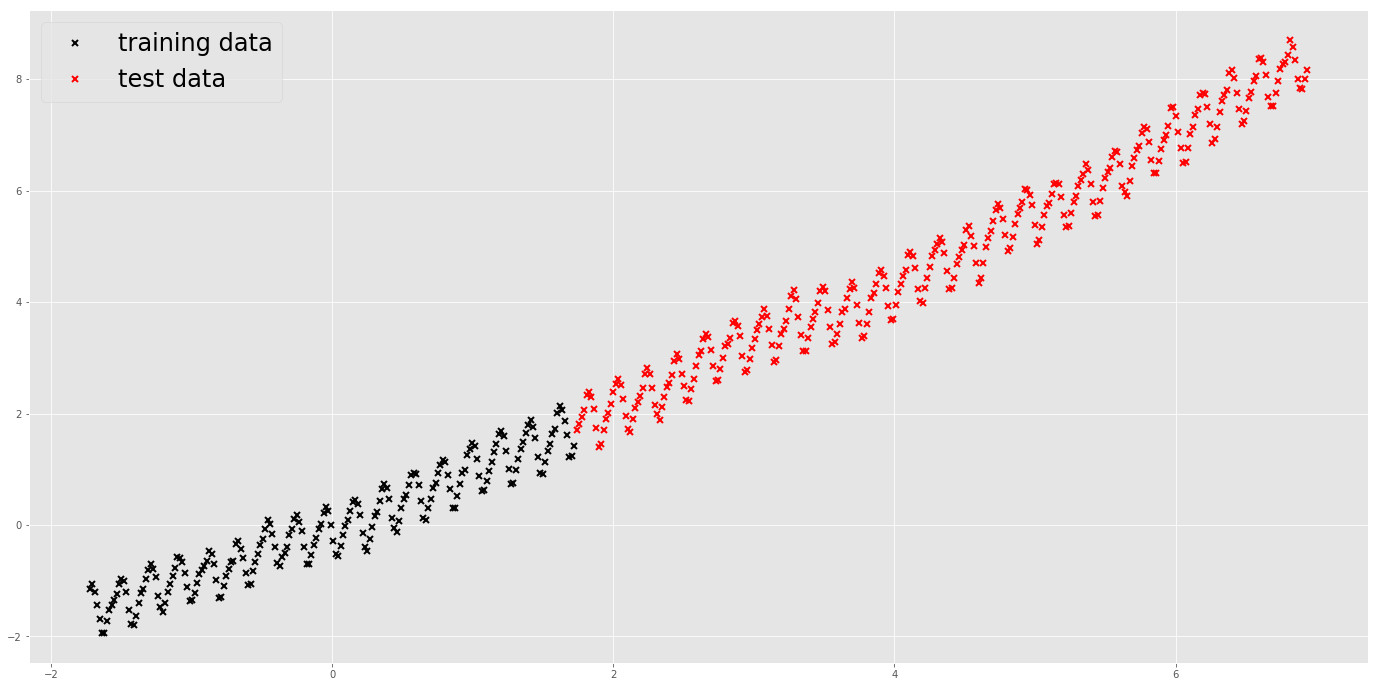

In [39]:
import scipy.io as sio
co2_data = sio.loadmat('../data/CO2data.mat')

X = np.float64(co2_data['xtrain'])
Y = np.float64(co2_data['ytrain'])
X_test = np.float64(co2_data['xtest'])
Y_test = np.float64(co2_data['ytest'])

X_test = (X_test - X.mean()) / X.std()
Y_test = (Y_test - Y.mean()) / Y.std()

X = (X - X.mean()) / X.std()
Y = (Y - Y.mean()) / Y.std()

plt.figure(figsize=(24, 12))
plt.plot(X, Y, 'kx', mew=2,label='training data')
plt.plot(X_test,Y_test,'rx',mew=2,label='test data')
plt.legend(loc='upper left',prop={'size': 24})

# Model 

We will use GPflow's Gaussian process regression `gpflow.models.GPR` with squared exponentiated kernel, linear & periodic kernel and spectral mixutre kernel with 10 kernel component & linear kernel.

In [5]:
D = np.shape(X)[1] # number of dimensions

# rbf kernel and GPR model
k_rbf = gpflow.kernels.RBF(D, lengthscales=0.3)
k_lin = gpflow.kernels.Linear(D)
k_per = gpflow.kernels.Periodic(D)
k_sum = k_rbf+k_lin+k_per
m_rbf = gpflow.models.GPR(np.float64(X), np.float64(Y), kern=k_sum)
m_rbf.likelihood.variance = 0.01

/l/gadichs1/conda_envs/deepgps/lib/python3.5/site-packages/gpflow/densities.py:89: UserWarning: Shape of x must be 2D at computation.
  warnings.warn('Shape of x must be 2D at computation.')


In [6]:
# Spectral Mixture kernel
Q = 10 # nnumber of mixtures

# first get the sm kernel params set
weights, means, scales = sm_init(train_x=X, train_y=Y, num_mixtures=Q)
k_sm = SpectralMixture(mixture_weights=weights,mixture_scales=scales, mixture_means=means,input_dim=D)
k_sm_sum=k_sm+k_lin
m_sm = gpflow.models.GPR(X, Y, kern=k_sm_sum)

Using default mixture = 1


/l/gadichs1/conda_envs/deepgps/lib/python3.5/site-packages/gpflow/densities.py:89: UserWarning: Shape of x must be 2D at computation.
  warnings.warn('Shape of x must be 2D at computation.')


# Spectral Kernel

Using default mixture = 1


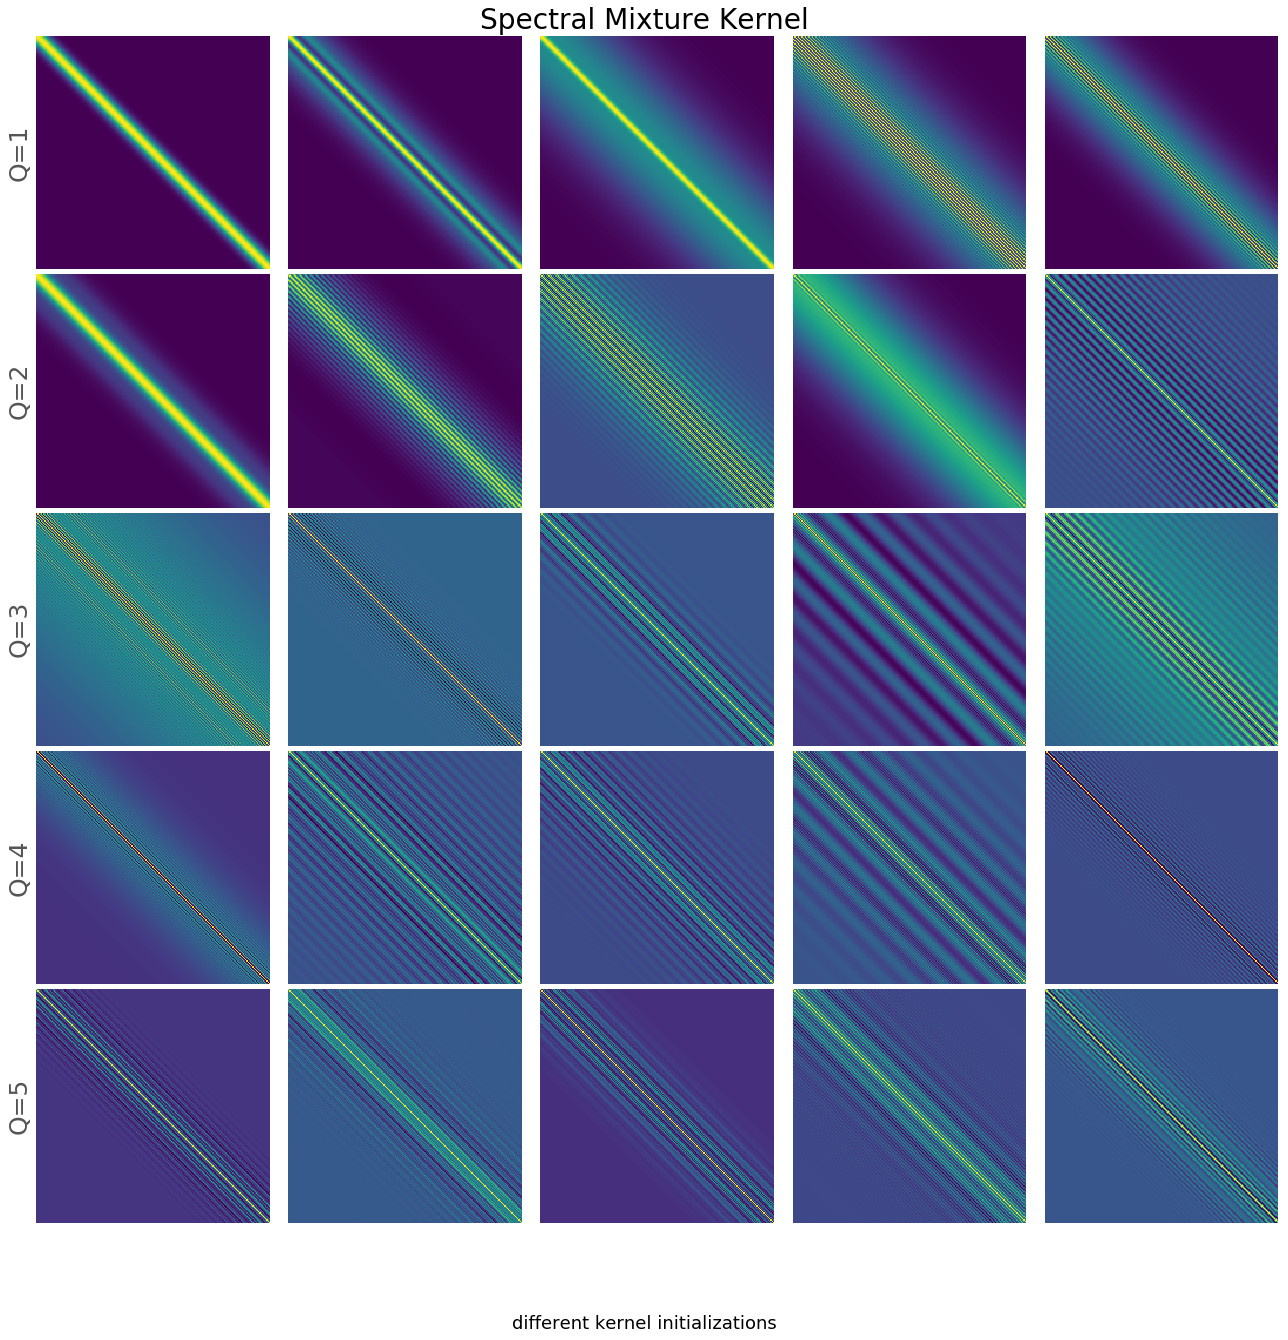

In [50]:
fig, ax = plt.subplots(5,5,figsize=(18,18), 
                       subplot_kw={'xticks': [], 'yticks': []})
fig.suptitle('Spectral Mixture Kernel', fontsize=28)
i=1
for j, ax in enumerate(fig.axes):
    weights,means,scales = sm_init(train_x=X,train_y=Y,num_mixtures=i)
    kern = SpectralMixture(num_mixtures=i,mixture_weights=weights,
                           mixture_scales=scales,mixture_means=means,
                           input_dim=4)
    K_xx= kern.compute_K_symm(X) 
    K_xx = (K_xx + K_xx.T)/2.
    ax.imshow(K_xx,interpolation='none')
    if j % 5 == 0:
        ax.set_ylabel('Q='+str(i))
        ax.yaxis.label.set_fontsize(25)
        i+=1
fig.text(0.5, -0.04, 'different kernel initializations', ha='center',fontsize=18)
plt.subplots_adjust(top=1.35)
fig.tight_layout()


# Initial Hyperparameter values

In [7]:
k_sum.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/kernels/0/lengthscales,Parameter,None,+ve,True,(),True,0.3
GPR/kern/kernels/0/variance,Parameter,None,+ve,True,(),True,1.0
GPR/kern/kernels/1/variance,Parameter,None,+ve,True,(),True,1.0
GPR/kern/kernels/2/period,Parameter,None,+ve,True,(),True,1.0
GPR/kern/kernels/2/variance,Parameter,None,+ve,True,(),True,1.0
GPR/kern/kernels/2/lengthscales,Parameter,None,+ve,True,(),True,1.0


In [8]:
k_sm.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/kernels/0/mixture_weights,Parameter,None,+ve,True,"(10,)",True,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ..."
GPR/kern/kernels/0/num_mixtures,Parameter,None,(none),False,(),True,1
GPR/kern/kernels/0/mixture_scales,Parameter,None,+ve,True,"(1, 10)",True,"[[4.777065621123003, 1.9948116452512357, 0.149..."
GPR/kern/kernels/0/mixture_means,Parameter,None,+ve,True,"(10, 1)",True,"[[0.0], [26.909441008417804], [5.7038916238432..."


# Prediction on unoptimized hyperparameters

In [9]:
def plot(m):
    #xx = np.linspace(-0.1, 5, 100)[:,None]
    xx = np.linspace(-2, 7, 10000)[:,None]
    #xx = np.vstack((X,X_test))
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(24, 12))
    plt.plot(X, Y, 'kx', mew=2)
    plt.plot(X_test, Y_test, 'rx', mew=2)
    plt.plot(xx, mean, 'b', lw=2)
    plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color='blue', alpha=0.2)
    #plt.xlim(-2, 2)

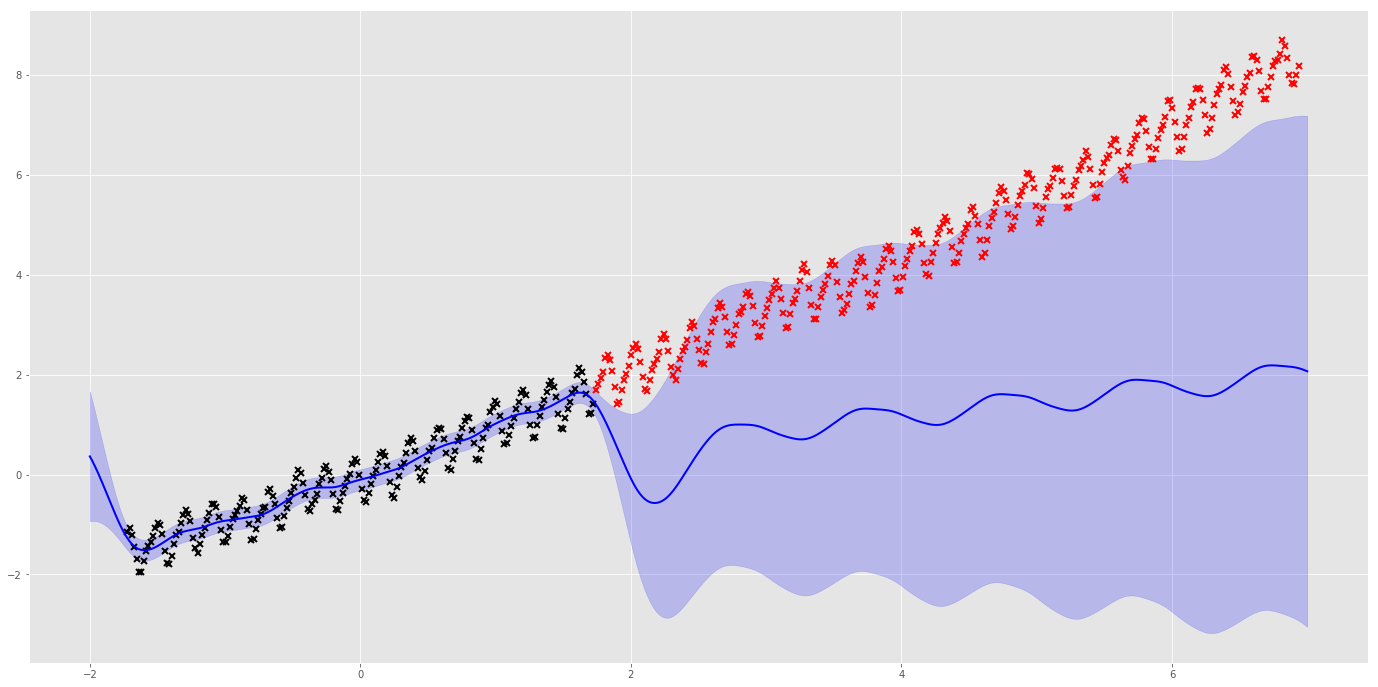

In [10]:
plot(m_rbf)

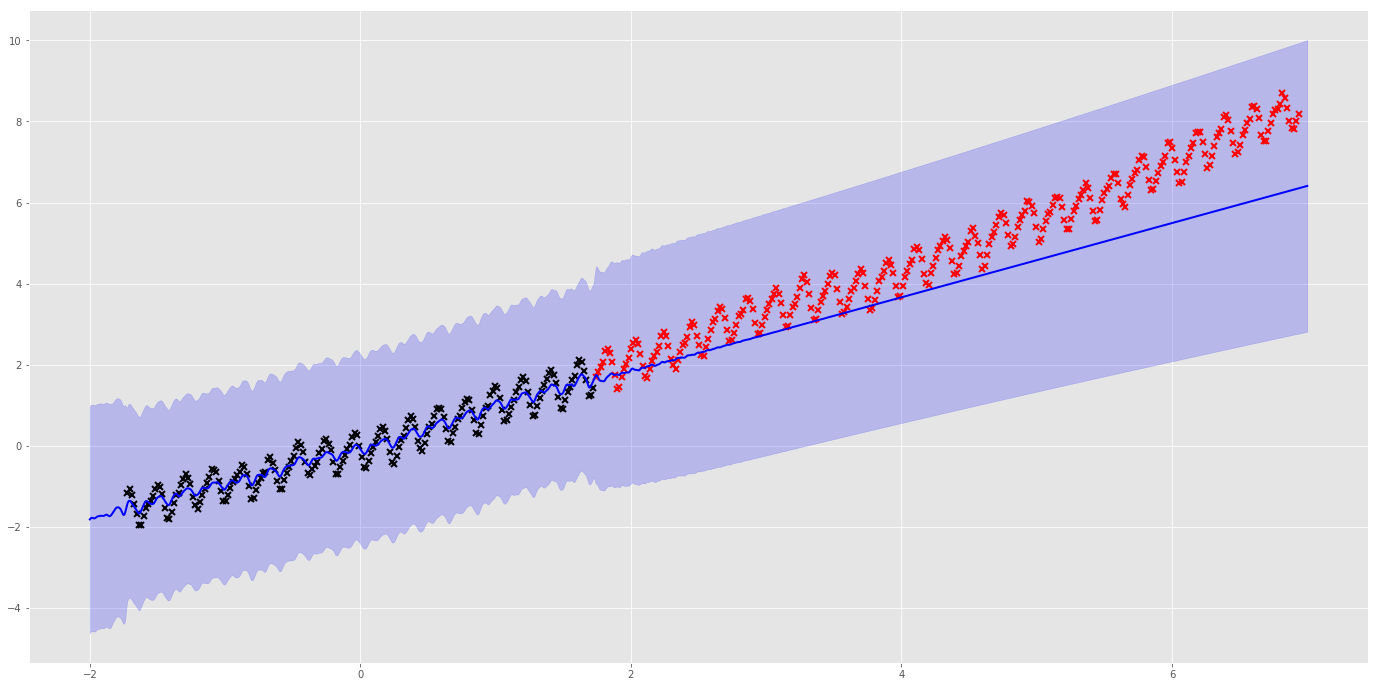

In [10]:
plot(m_sm)

# Hyperparameter Optimization

In [11]:
gpflow.training.AdamOptimizer(0.01).minimize(m_rbf, maxiter=10000)

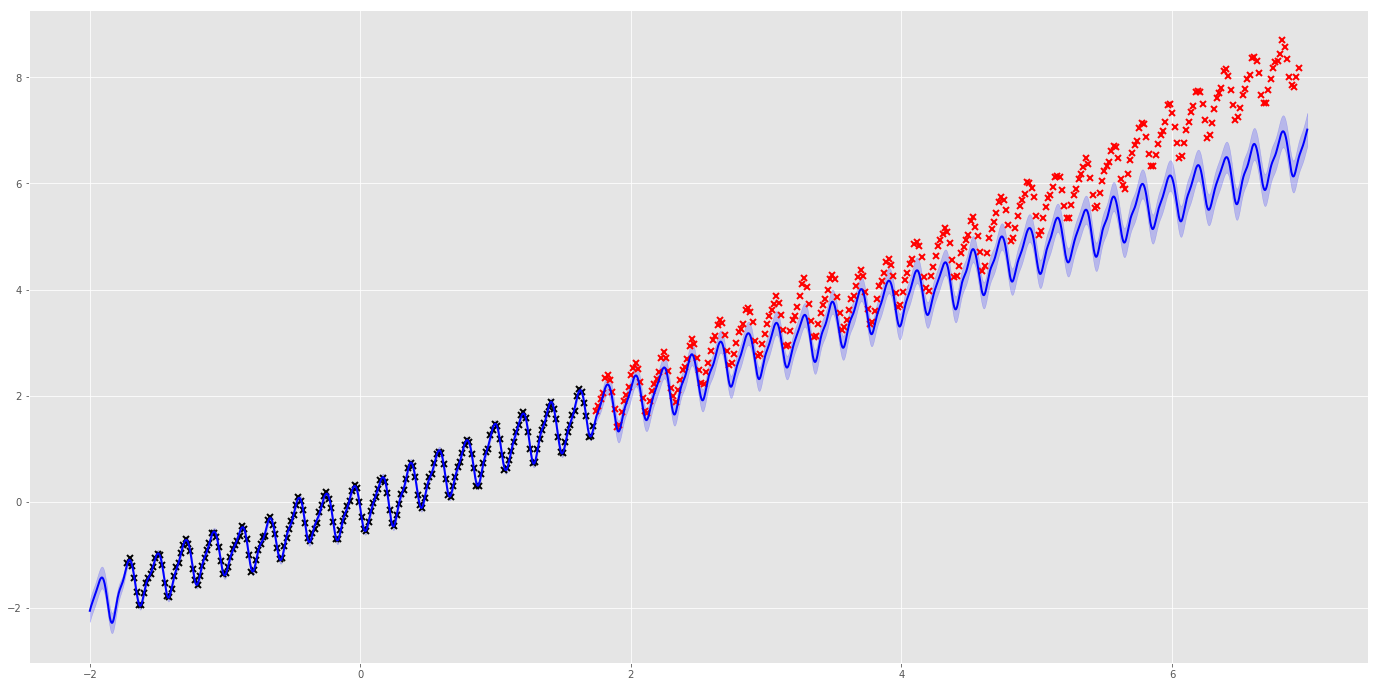

In [12]:
plot(m_rbf)

In [13]:
k_sm_sum.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/kernels/0/mixture_weights,Parameter,None,+ve,True,"(10,)",True,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ..."
GPR/kern/kernels/0/num_mixtures,Parameter,None,(none),False,(),True,1
GPR/kern/kernels/0/mixture_scales,Parameter,None,+ve,True,"(1, 10)",True,"[[4.777065621123003, 1.9948116452512357, 0.149..."
GPR/kern/kernels/0/mixture_means,Parameter,None,+ve,True,"(10, 1)",True,"[[0.0], [26.909441008417804], [5.7038916238432..."
GPR/kern/kernels/1/variance,Parameter,None,+ve,True,(),True,0.908407791235137


In [14]:
gpflow.training.AdamOptimizer(0.01).minimize(m_sm, maxiter=10000)

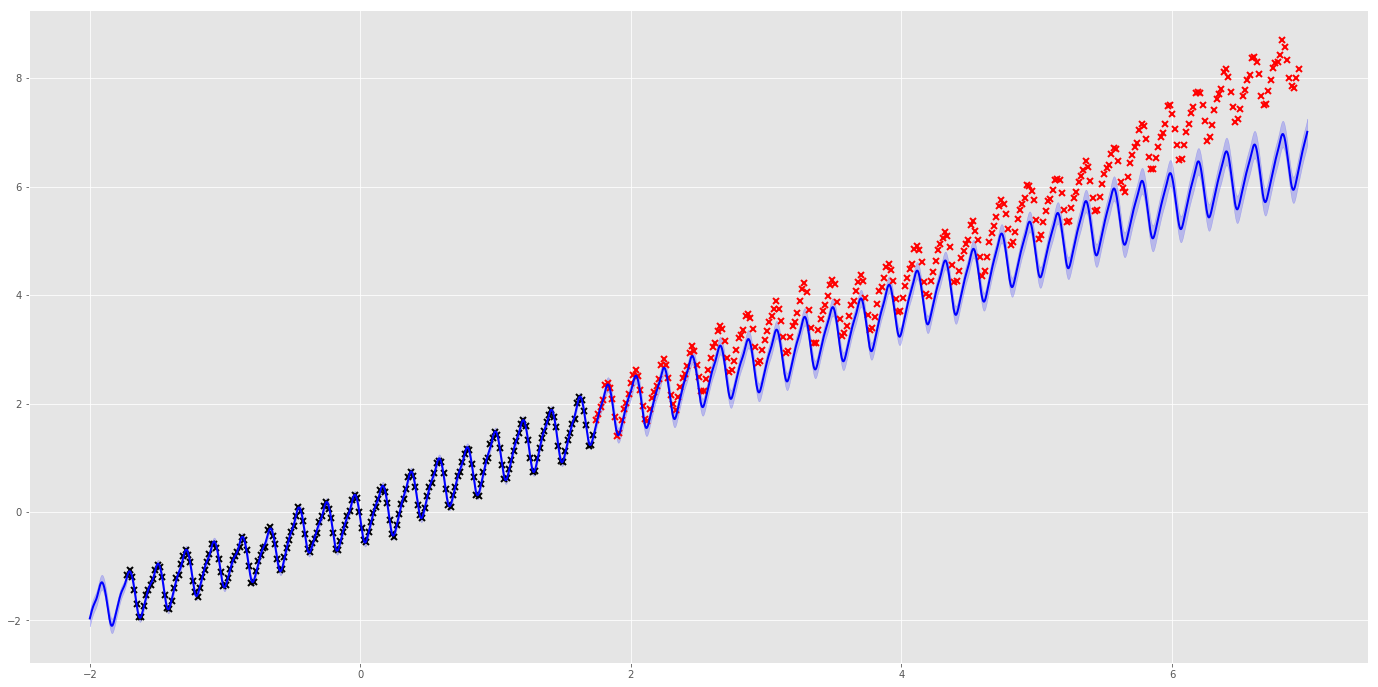

In [15]:
plot(m_sm)

# Kernel post optimization

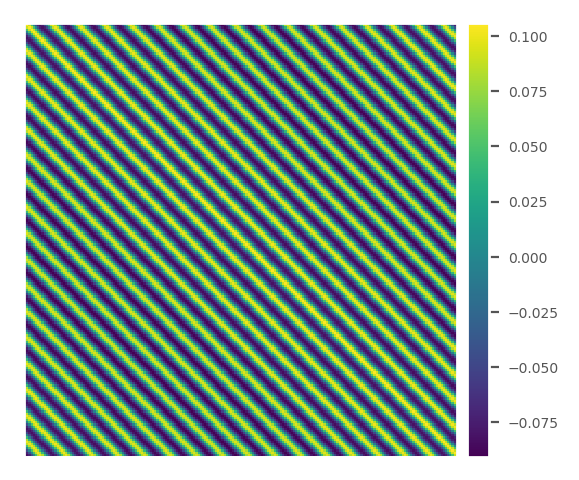

In [53]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


K_xx= m_sm.kern.kernels[0].compute_K_symm(X)
K_xx = (K_xx + K_xx.T)/2.
fig = plt.figure(figsize=(3, 3),dpi=200)
image = plt.imshow(K_xx,interpolation='none')
ax = plt.gca();
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(image, orientation='vertical',cax=cax,shrink=0.5, aspect=20, fraction=.12)
# access to cbar tick labels:
cbar.ax.tick_params(labelsize=5) 


# Major ticks
ax.set_xticks([]);
ax.set_yticks([]);

# Labels for major ticks
ax.set_xticklabels([]);
ax.set_yticklabels([]);

# Gridlines based on minor ticks
ax.grid(b=False)

## Validating the kernel

In [17]:
_,s,_ = np.linalg.svd(K_xx)
print(np.sort(s)[0:5])

[1.17287857e-16 2.69874754e-16 3.98437470e-16 5.09190299e-16
 5.64008690e-16]


## Optimized Parameters

In [18]:
m_sm.kern.kernels[0].mixture_weights.value**2,np.transpose(m_sm.kern.kernels[0].mixture_means.value)

(array([4.95309941e-06, 1.02322949e-12, 8.59567237e-03, 1.07835833e-12,
        3.16206524e-10, 5.11472111e-07, 1.02418269e-09, 5.27321064e-10,
        1.43698935e-05, 3.86486477e-05]),
 array([[1.00000000e-06, 2.88671526e+01, 4.80938138e+00, 2.17749277e+01,
         1.92304104e+01, 1.34421908e+00, 1.92304780e+01, 1.92304515e+01,
         2.88940299e-01, 9.62167450e+00]]))

## Spectral density 

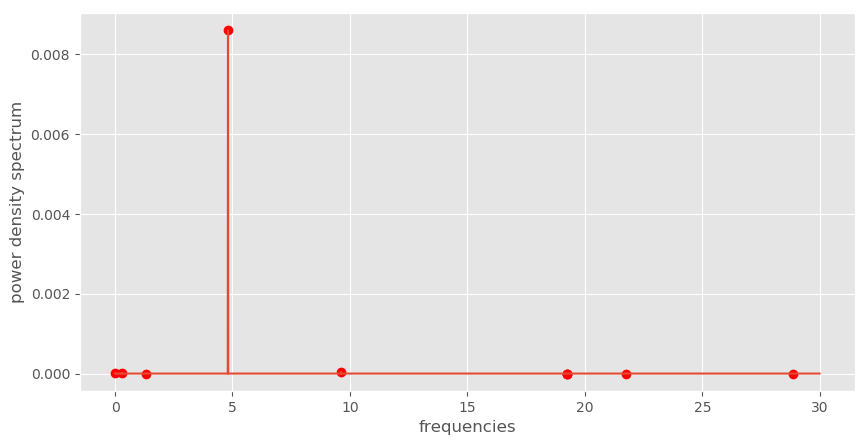

In [19]:
freq= np.around(np.squeeze(np.transpose(m_sm.kern.kernels[0].mixture_means.value)),decimals=2)
coeff = (m_sm.kern.kernels[0].mixture_weights.value**2)
idx = np.squeeze(np.argsort(freq))

xx = np.arange(0,30,0.01)
yy = np.zeros_like(xx)
yy[np.searchsorted(xx, freq)] = coeff

plt.figure(figsize=(10, 5),dpi=100)
plt.plot(freq[idx],coeff[idx],'ro')
plt.plot(xx,yy)
plt.xlabel('frequencies')
plt.ylabel('power density spectrum')
plt.show()